In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import Aer,execute, transpile, assemble
from qiskit.circuit.library.standard_gates import RXGate, RYGate, MCXGate
from qiskit.quantum_info import Operator
from qiskit.extensions import UnitaryGate
from qiskit.tools.visualization import plot_histogram, plot_state_city
from qiskit.circuit import Parameter, ParameterVector

from scipy.optimize import minimize
from scipy.stats import entropy
import random

from scipy.special import rel_entr
import yfinance as yf
import pandas as pd
from collections import defaultdict
import time

In [3]:
# Loss function: KL divergence
def kl_divergence(trained, target):
    epsilon = 1e-8
    return np.sum(rel_entr(trained + epsilon, target + epsilon))

# Loss function: MSE
def MSE_Loss(real, target):
    # Use MSE as loss function
    
    loss = 0
    for i in range(len(real)):
        loss += (10*real[i]-10*target[i])**2

    return loss/len(real)

# Loss function: Kolmogorov-Smirnov
def Kolmogorov_Smirnov(real, target):
    # Use Kolmogorov-Smirnov as loss function
    loss = 0
    for i in range(len(real)):
        loss += np.max(np.abs(np.cumsum(real[i])-np.cumsum(target[i])))
    return loss
# Loss function: Huber loss    
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    abs_error = np.abs(error)

    # Calculate Huber loss based on the condition
    huber_loss = np.where(abs_error <= delta, 0.5 * np.square(error), delta * abs_error - 0.5 * np.square(delta))

    return np.mean(huber_loss)

def CrossEntropy(real, target):
    eps = np.finfo(float).eps
    cross_entropy = -np.sum(target * np.log(real + eps))

    return cross_entropy

In [4]:
# record output
def count2distribution(counts,nq):
    
    # initial
    output = np.zeros(2**nq)
    
    # record
    for i in range(2**nq):
        x_label = str(np.binary_repr(i, nq))
        if x_label in counts:
            output[i] = counts[x_label]
    
    return output/sum(output)

In [5]:
def float_range(num, spacing):
    arr = np.arange(-spacing*(num+1)/2,spacing*(num+1)/2, spacing)
    return arr

In [6]:
def shift_matrix(NumQubits, shift, direction):
    
    if direction == 'left':
        matrix = np.roll(np.identity(2**NumQubits), shift, axis=1)
    else:
        matrix = np.roll(np.identity(2**NumQubits), shift, axis=0)
    
    return matrix

In [7]:
def multi_conditional_shift_operator(Num_CoinQubits, Num_PositionQubits, direction):
     
     matrix = np.identity(2**(Num_CoinQubits+Num_PositionQubits))

     # position space
     identiy = np.identity(2**Num_PositionQubits)

     for i in range(Num_CoinQubits):
          block_list_left =  [np.identity(2) for _ in range(Num_CoinQubits)]
          block_list_left[i] = np.array([[1, 0],[0, 0]])
          block_list_right =  [np.identity(2) for _ in range(Num_CoinQubits)]
          block_list_right[i] = np.array([[0, 0],[0, 1]])
          temp_C_left = 1
          temp_C_right = 1
          for j in range(Num_CoinQubits):
               temp_C_left = np.kron(block_list_left[j],temp_C_left)
               temp_C_right = np.kron(block_list_right[j],temp_C_right)
          if direction == 'left':
               temp_T = shift_matrix(Num_PositionQubits, shift=2**i, direction='left')
               temp_S = np.kron(temp_C_left, temp_T)+np.kron(temp_C_right, identiy)
          else:
               temp_T = shift_matrix(Num_PositionQubits, shift=2**i, direction='right')
               temp_S = np.kron(temp_C_left, identiy)+np.kron(temp_C_right, temp_T)
          matrix = np.dot(temp_S,matrix)

     return matrix

In [8]:
def QW_with_multicoin(Num_CoinQubits, Num_PositionQubits, params ,output_circ=False):

    qr_x = QuantumRegister(Num_PositionQubits, name='x')

    # coin space
    qr_c = QuantumRegister(Num_CoinQubits, name='c')
    
    # classical bit
    cr = ClassicalRegister(Num_PositionQubits, name='cbits')
    
    # quantum circuit
    circ = QuantumCircuit(qr_x, qr_c, cr)

    MCSr_gate = UnitaryGate(multi_conditional_shift_operator(Num_CoinQubits, Num_PositionQubits, direction='right'),label=r'$S_{+}$')
    MCSl_gate = UnitaryGate(multi_conditional_shift_operator(Num_CoinQubits, Num_PositionQubits, direction='left'),label=r'$S_{-}$')

    # initialize
    for i in range(Num_CoinQubits):
        # u-gate
        circ.u(params[(i)],params[(i)+1],params[(i+2)],qr_c[i])
        #entangle all coin qubits
        for j in range(i):
            circ.cx(qr_c[j],qr_c[i])
        #u-gate
    for i in range(Num_CoinQubits):
        circ.u(params[(i+3)],params[(i+4)],params[(i+5)],qr_c[i])

    circ.barrier()

    # S+
    circ.append(MCSr_gate, range(Num_CoinQubits+Num_PositionQubits))

    circ.barrier()

    for i in range(Num_CoinQubits):
        #U-gate
        circ.u(params[(i+6)],params[(i+7)],params[(i+8)],qr_c[i])
        #entangle all coin qubits
        for j in range(i):
            circ.cx(qr_c[i],qr_c[j])
        #U-gate
    for i in range(Num_CoinQubits):
        circ.u(params[(i+9)],params[(i+10)],params[(i+11)],qr_c[i])
        
    circ.barrier()

    # S-
    circ.append(MCSl_gate, range(Num_CoinQubits+Num_PositionQubits))

    circ.measure(qr_x, cr)

    backend = Aer.get_backend('aer_simulator')
    job = execute(circ, backend, shots=10000 ) 
    counts = job.result().get_counts()
    distribution = count2distribution(counts, Num_PositionQubits)

    if output_circ == True:
        return circ,distribution
    else:
        return distribution

In [9]:
# Number of coin qubits and position qubits 
Num_CoinQubits = 3
Num_PositionQubits = 4
params = np.random.uniform(0,2*np.pi, 12*Num_CoinQubits)
circ, position_distribution = QW_with_multicoin(Num_CoinQubits, Num_PositionQubits, params, output_circ=True)

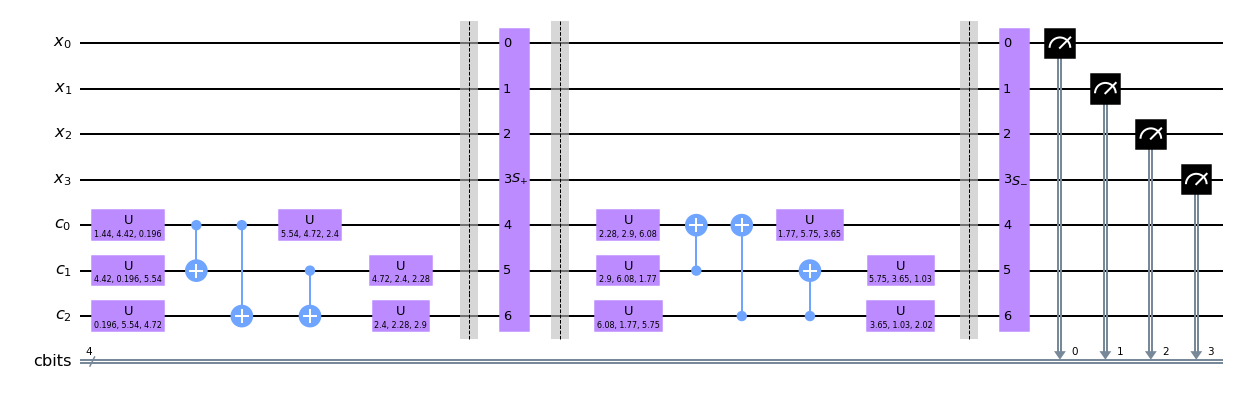

In [10]:
circ.draw('mpl')

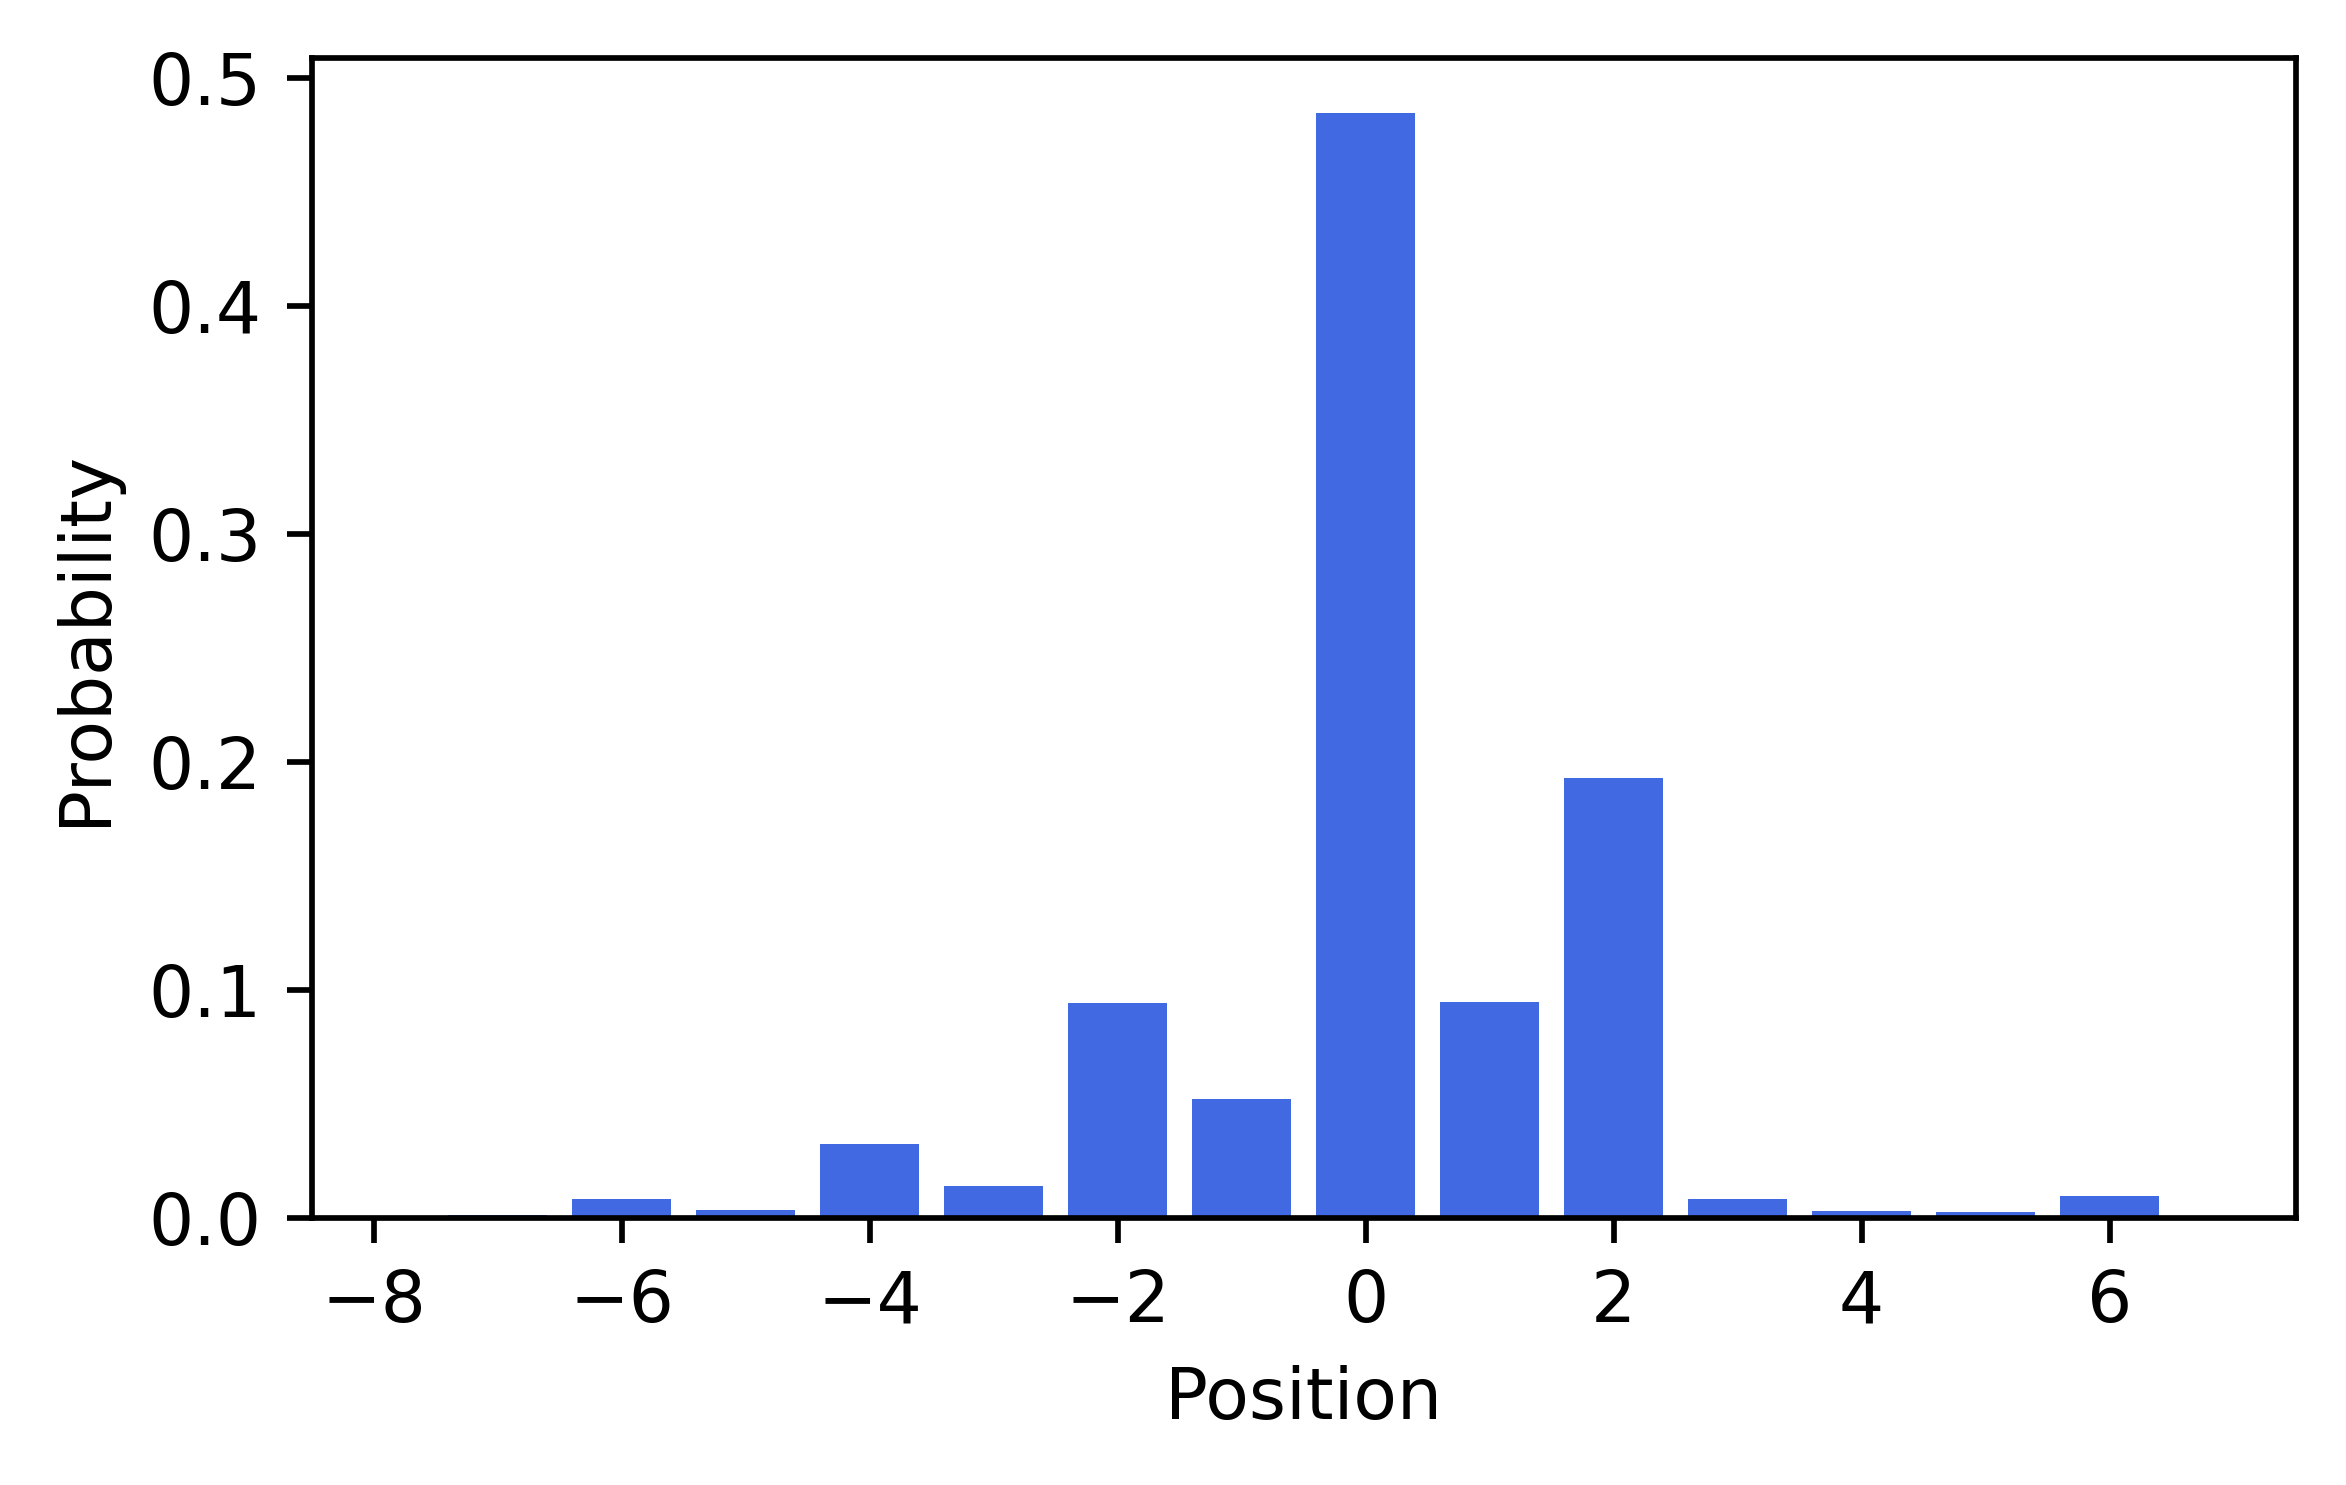

In [11]:
fig, ax = plt.subplots(figsize=(5,3), dpi=512)

x = np.arange(-1*2**(Num_PositionQubits-1),2**(Num_PositionQubits-1))

plt.bar(x, np.roll(position_distribution, 2**(Num_PositionQubits-1)), width=0.8, color="royalblue")

plt.xlim(min(x)-0.5,max(x)+0.5)
plt.xlabel('Position')
plt.ylabel('Probability')
plt.show()

In [12]:
import yfinance as yf
import pandas as pd
import numpy as np

# Downloading data set
Ticker_list = ["AAPL", "MSFT", "AMZN", "GOOGL","JPM", "^GSPC", "^NDX","NVDA", "TSLA", "JNJ"]
start_date = "2023-01-01"
end_date = "2023-03-31"
data = yf.download(Ticker_list, start=start_date, end=end_date)
data = data.interpolate()
data = data.loc[:, "Adj Close"]
return_data = data.pct_change().dropna()

Num_PositionQubits = 4
bound = float_range(2**Num_PositionQubits, 0.01)  # create bins
stock_distributions = defaultdict(list)
# Select the stock you are interested in
# Loop over each stock
for stock_interest in Ticker_list:
    dist = np.zeros(2**Num_PositionQubits)
    single_data = return_data[stock_interest]
    for i in range(len(single_data)):
        temp = single_data[i] 
        for j in range(2**Num_PositionQubits):
            if temp > bound[j] and temp < bound[j+1]:
                dist[j] += 1 

    # Normalizing the distribution
    real_target = dist/sum(dist)
    
    # Add the distribution to the defaultdict
    stock_distributions[stock_interest].append(real_target)




[*********************100%***********************]  10 of 10 completed


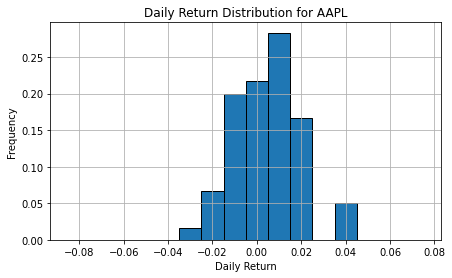

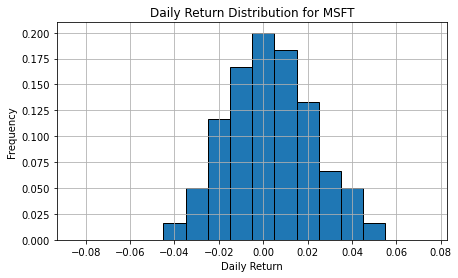

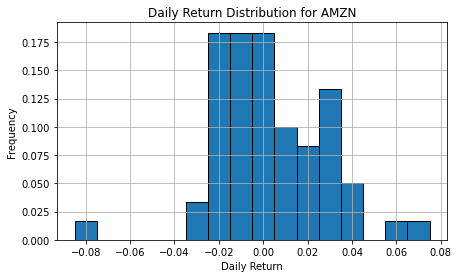

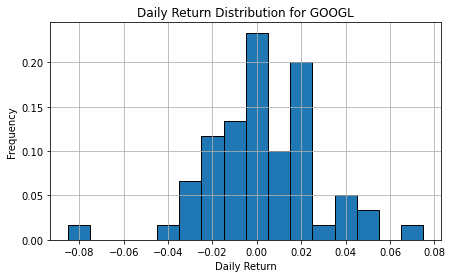

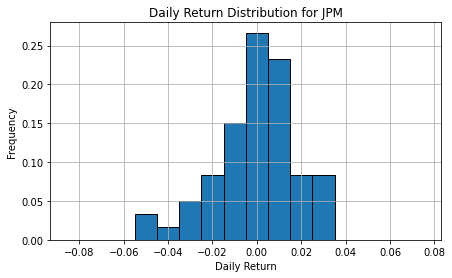

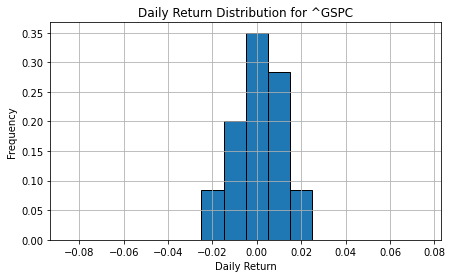

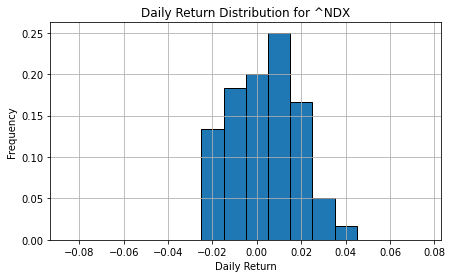

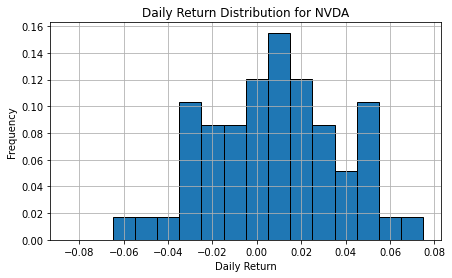

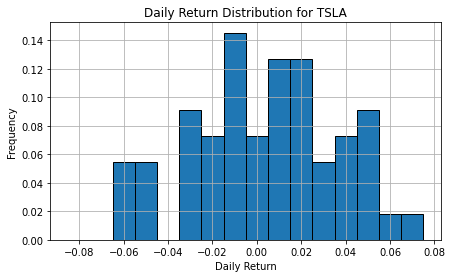

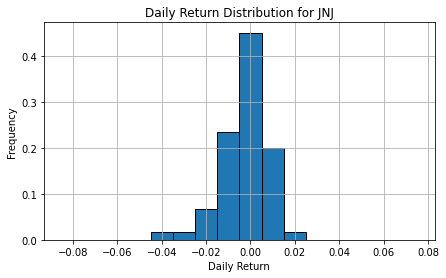

In [13]:
for i in range(len(Ticker_list)):
    plt.figure(figsize=(7,4))
    plt.bar(bound[:-1], stock_distributions[Ticker_list[i]][0], width=np.diff(bound), edgecolor="black", align="edge")
    plt.title('Daily Return Distribution for {}'.format(Ticker_list[i]))
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.grid()
    plt.show()

In [14]:
def cost_function(params, target):
    
    global opt, Num_CoinQubits, Num_PositionQubits, position_shift
    
    #position_shift = 2**(nq-1)
    # target function
    
    trained = QW_with_multicoin(Num_CoinQubits, Num_PositionQubits, params, output_circ = False)
    cost = MSE_Loss(np.roll(trained,  position_shift), target)
    
    return cost

In [15]:
def cost_function_MSE(params, target):
    
    global opt, Num_CoinQubits, Num_PositionQubits, position_shift

    
    # target function
    trained = QW_with_multicoin(Num_CoinQubits, Num_PositionQubits, params, output_circ = False)
    cost = MSE_Loss(np.roll(trained, position_shift), target)
    
    #print(cost)
    
    return cost

In [16]:
def cost_function_KL(params, target):
    
    global opt,  Num_CoinQubits, Num_PositionQubits, position_shift
    
    # target function
    
    trained = QW_with_multicoin(Num_CoinQubits, Num_PositionQubits, params, output_circ = False)
    cost = kl_divergence(np.roll(trained,  position_shift), target)
    
    #print(cost)

    return cost

In [17]:
def callback(xk, *args, **kwarg):
    global errors

    cost = cost_function(xk, Num_CoinQubits, Num_PositionQubits,target)
    errors.append(cost)

In [18]:
def callback_MSE(xk, *args, **kwarg):
    global errors

    cost = cost_function_MSE(xk, Num_CoinQubits, Num_PositionQubits, target)
    errors.append(cost)

In [19]:
def callback_KL(xk, *args, **kwarg):
    global errors

    cost = cost_function_KL(xk, Num_CoinQubits, Num_PositionQubits, target)
    errors.append(cost)

In [20]:
#cost function list
costFucntion_list = ["MSE_Loss", "KL_divergence"]

#parameter
iteration = 200

Num_CoinQubits = 3
Num_PositionQubits = 4
position_shift = 2**(Num_PositionQubits-1)
costFucntion_list = ["MSE_Loss", "KL_divergence"]
params = np.random.uniform(0,2*np.pi, 12*Num_CoinQubits)
target = stock_distributions[Ticker_list[2]][0]
cost_function_name = costFucntion_list[0]
errors = []  # Reset errors list


out_mse = minimize(cost_function_MSE, x0 = params, method="COBYLA", args= (target), options={'maxiter': iteration})
err_mse = out_mse.fun
best_params_kl = out_mse['x']

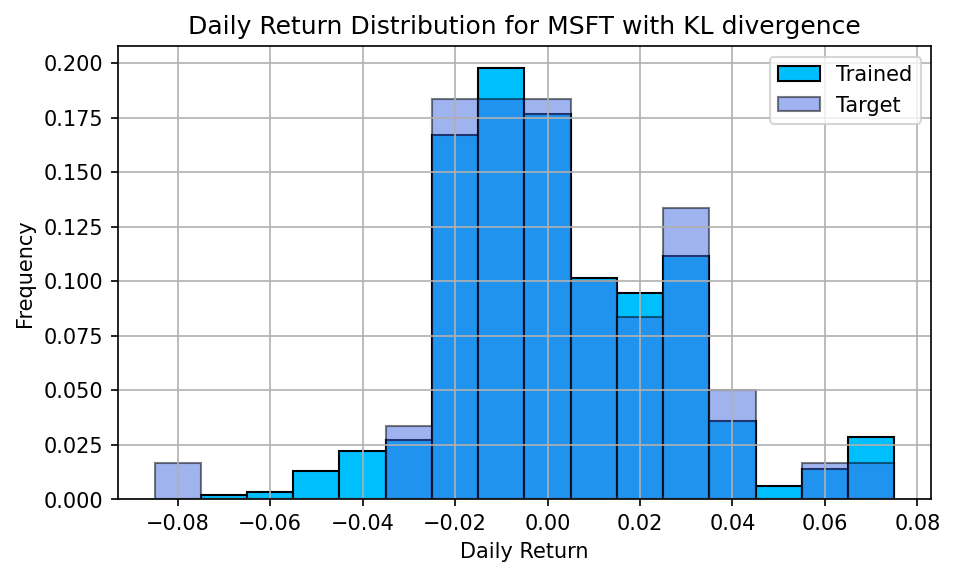

In [ ]:
#plot the distribution and result(bar) with target(bar)
traine_mse = QW_with_multicoin(Num_CoinQubits, Num_PositionQubits, best_params_kl, output_circ = False)
plt.figure(figsize=(7,4), dpi= 150)
plt.bar(bound[:-1], np.roll(traine_mse, position_shift), width=np.diff(bound), edgecolor="black", align="edge", label="Trained", color = "deepskyblue")  
plt.bar(bound[:-1], target, width=np.diff(bound), edgecolor="black", align="edge", label="Target", color = "royalblue", alpha=0.5) 
plt.title('Daily Return Distribution for {} with KL divergence'.format(Ticker_list[1]))
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()


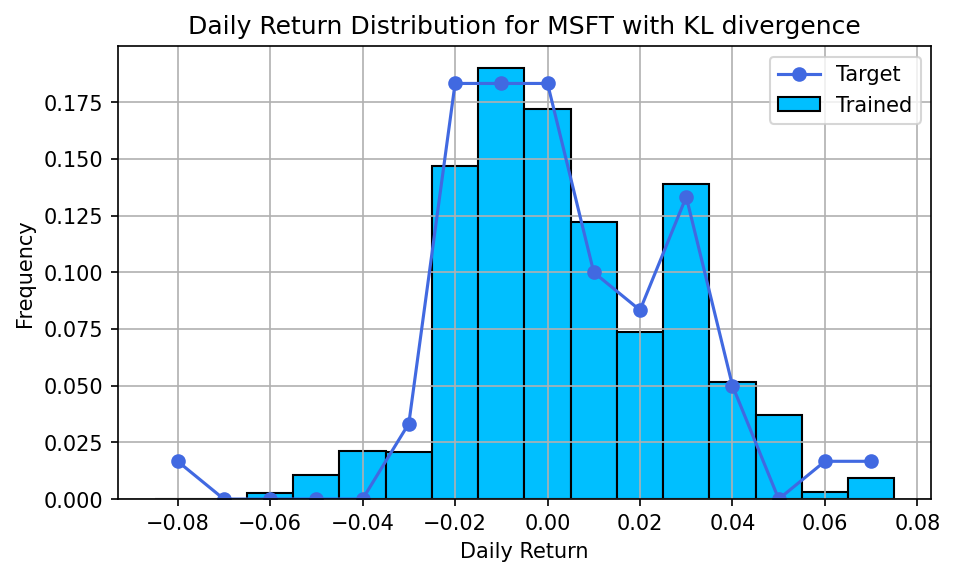

In [21]:
#plot the distribution and result(bar) with target(dot in the mid)
traine_mse = QW_with_multicoin(Num_CoinQubits, Num_PositionQubits, best_params_kl, output_circ = False)

# Calculate the midpoints of the bins
midpoints = (bound[:-1] + bound[1:]) / 2

plt.figure(figsize=(7,4), dpi= 150)
plt.bar(bound[:-1], np.roll(traine_mse, position_shift), width=np.diff(bound), edgecolor="black", align="edge", label="Trained", color = "deepskyblue")
plt.plot(midpoints,  target, "-o", color = "royalblue", label="Target")
plt.title('Daily Return Distribution for {} with KL divergence'.format(Ticker_list[1]))
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()





Text(0.5, 1.0, 'Error Plot_MSE_Loss for Binomail probability')

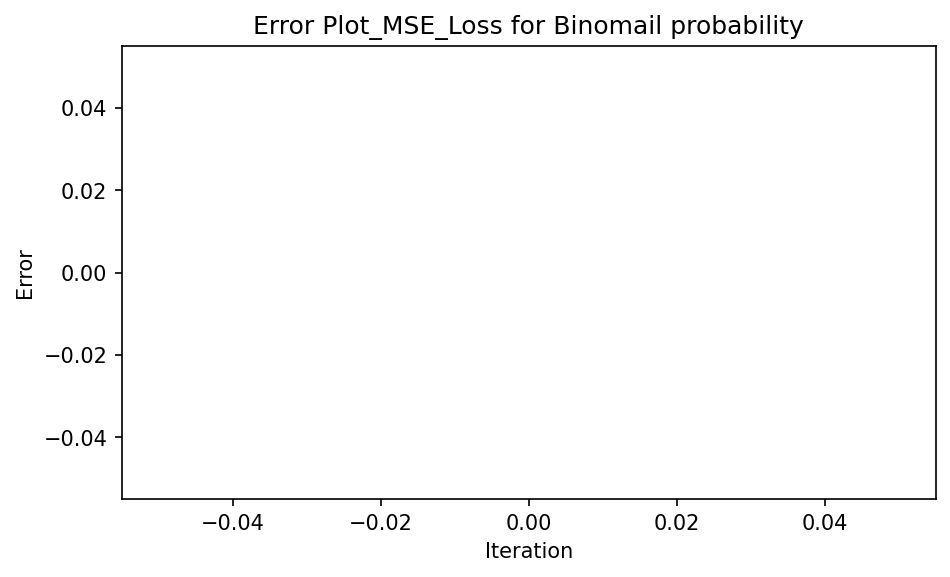

In [ ]:
# Plot errors
plt.figure(figsize=(7,4), dpi = 150)
plt.plot(errors)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Error Plot_{} for Binomail probability'.format(cost_function_name))
